# Getting start with Bodo

**Bodo** is the key part of the **Bodo.ai** platform, a solution that provides a user-friendly interface for data team, through Jupyter Notebooks and Job instances easily integrated with AWS account. **Bodo** was built on top of very well known open source technologies such as **Numba**, **Pandas**, **Numpy**, **MPI** and **LLVM**.


![https://bodo.ai/technology/](img/bodo-technologies.png)


You can write **bodo** code as easy as you would write **numba** code, just using a `jit`(just-in-time) decorator, for example:


In [1]:
import time

import bodo
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# lazy compilation
@bodo.jit
def calc_add(series: pd.Series, scalar: int) -> pd.Series:
    return series + scalar


calc_add(pd.Series(range(10)), 100)

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


0    100
1    101
2    102
3    103
4    104
5    105
6    106
7    107
8    108
9    109
dtype: int64

As you can see, you can write thecode in the same way you would write it using **numba**. 
Also, you can also decide to use lazy or eager compilation 
(see [numba documentation](https://numba.pydata.org/numba-doc/latest/user/jit.html)).

When using lazy compilation, you don't need to specify the allowed signatures for the 
function you want to compile using **bodo**. For example, when you decorated `calc_add` 
with `bodo.jit`, you didn't specify what data type is used by each parameter neither 
the data type returned. As you can observe, it just have the type annotation, but it is not
enough to compile the function. Instead, with you want to compile the function for a specific
type, you need to do it with the `jit` decorator as shown below:

In [3]:
# eager compilation
@bodo.jit('int64(int64, int64)')
def calc_sum(scalar1: int, scalar2: int):
    return scalar1 + scalar2


calc_sum(10, 100)

110

In this case, you will compile the function before the function call, so when 
the function is called, it didn't need to spent time compiling the function.
Let's check the execution time difference between lazy, eager and pure `pandas`/`numpy` approach.

In [4]:
data = pd.Series(range(100))
data.name = 'age'
data

0      0
1      1
2      2
3      3
4      4
      ..
95    95
96    96
97    97
98    98
99    99
Name: age, Length: 100, dtype: int64

In [5]:
# pure pandas/numpy approach
def calc_add(series: pd.Series, scalar: int) -> pd.Series:
    return series + scalar


t = time.time()
calc_add(data, 100)
print('Execution time:', time.time() - t, 's')

Execution time: 0.0022001266479492188 s


As you can see, using pure **pandas/numpy** this operation takes ~0.002s to finish.
Now, lets take a look how to "jitify" this using **bodo** for **lazy compilation**.

In [6]:
lazy_calc_add = bodo.jit(calc_add)

t = time.time()
lazy_calc_add(data, 100)
print('Execution time:', time.time() - t, 's')

Execution time: 0.3691263198852539 s


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


The lazy compilation took more than 100 times than the pure 
**pandas/numpy** approach. That happens because there is an overhead for the 
compilation. Now, that the function is already "jitified", lets take a look
if has any peformance improvement.


In [8]:
t = time.time()
lazy_calc_add(data, 100)
print('Execution time:', time.time() - t, 's')

Execution time: 0.0005719661712646484 s


The `lazy_calc_add` now performes much faster than the first time, 
also much faster than the pure **pandas/numpy** version.
That is a amazing improvement! Maybe if you run it again, maybe the time execution would be 
different. So, in the next section, we will get the average of 1000 executions to have a better 
idea about the performance. Also, it is good to have in mind that the tests are using a very small
dataset. We will add more tests using a larger dataset too to check the difference.

In [10]:
SE_INDEX_RANGE_TYPE = bodo.SeriesType(
    dtype=bodo.int64, 
    index=bodo.RangeIndexType(bodo.none),
    name_typ=bodo.string_type
)

SE_INDEX_NUMERIC_TYPE = bodo.SeriesType(
    dtype=bodo.int64, 
    index=bodo.NumericIndexType(bodo.int64),
    name_typ=bodo.string_type
)

SE_TYPES = [
    SE_INDEX_RANGE_TYPE(SE_INDEX_RANGE_TYPE, bodo.int64),
    SE_INDEX_NUMERIC_TYPE(SE_INDEX_NUMERIC_TYPE, bodo.int64)
]

eager_calc_add = bodo.jit(SE_TYPES)(calc_add)

t = time.time()
eager_calc_add(data, 100)
print('Execution time:', time.time() - t, 's')

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


Execution time: 0.0004069805145263672 s


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


In its first execution, the execution time of the **eager compiled** function
was near the second execution of the **lazy compiled** function.

## Benchmark

Now, lets measure the time for 1000 executions and take the average for each approach for both a small and large dataset.

So, first, we will need to download some data. For this benchmark, we will use the 2015 NYC Taxi Trip dataset,
available at `https://s3.amazonaws.com/nyc-tlc/trip+data`. For our propose, we will just download the first
3 months. To download the data, uncomment the following cell, set `DATA_DIR` to your data folder and run it.

In [11]:
"""
%%bash

URL_ROOT=https://s3.amazonaws.com/nyc-tlc/trip+data
DATA_DIR=/work/bodoai/dataset/nyc-trip-2015

mkdir -p ${DATA_DIR} 

for i in {1..3}; do
    month=`printf "%2.0d\n" $i |sed "s/ /0/"`;
    FILENAME=yellow_tripdata_2015-${month}.csv;
    wget -c ${URL_ROOT}/${FILENAME} -O ${DATA_DIR}/${FILENAME};
done
""";

Second step, join the three `CSV` trip files to a single `Parquet` file 
(skip the following cell if you already have the `parquet` data):

In [12]:
dfs = []
data_dir = './data/nyc-trip-2015'

for i in range(1, 4):
    df = pd.read_csv(
        f'{data_dir}/yellow_tripdata_2015-{str(i).rjust(2, "0")}.csv',
        parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
    )
    dfs.append(df)
    del df

df = pd.concat(dfs)
df.to_parquet('./data/nyc-trip-2015/q1.pq')
del df

In [13]:
large_dataset = pd.read_parquet('./data/nyc-trip-2015/q1.pq').passenger_count

In [14]:
dataset = {'small': data, 'large': large_dataset}
methods = {
    'pure_pandas_numpy': calc_add, 
    'lazy_compilation': bodo.jit(calc_add),
    'eager_compilation': bodo.jit(SE_TYPES)(calc_add)
}
execution_time = {'small': {}, 'large': {}}

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(
/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


In [16]:
N = 1000

for d_name, d in dataset.items():
    # force the recreation of lazy_compilation
    methods['lazy_compilation'] = bodo.jit(calc_add)
    for m_name, m in methods.items():
        t = 0
        for _ in range(n):
            t1 = time.time()
            m(d, N)
            t += time.time() - t1
        
        execution_time[d_name][m_name] = t/N
execution_time

/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(
/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


{'small': {'pure_pandas_numpy': 8.463740348815918e-05,
  'lazy_compilation': 0.00033594441413879397,
  'eager_compilation': 0.00011157751083374024},
 'large': {'pure_pandas_numpy': 0.0470913679599762,
  'lazy_compilation': 0.07897129654884338,
  'eager_compilation': 0.0794542350769043}}

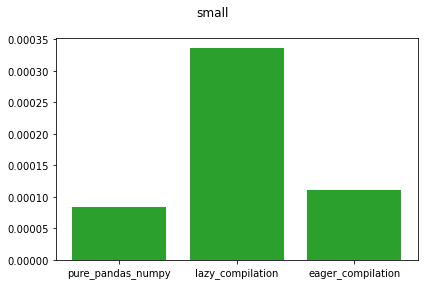

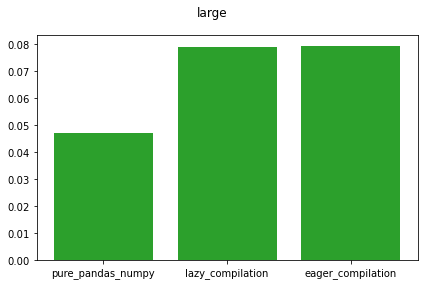

In [17]:
for size_name, size_collection in execution_time.items():
    fig = plt.figure()
    
    for method_name, method_time in size_collection.items():
        plt.bar(size_collection.keys(), size_collection.values())
        
    
    plt.suptitle(size_name)
    fig.tight_layout()
    fig.show()

As we can observe, for small dataset the compilation overhead for **lazy compilation** increase a lot the 
execution time, but for large dataset it doesn't have a considered impact. 

Another thing we can observe is that pure **numpy/pandas** has a better performance compared to
both **eager compilation** and **lazy compilation**. That is because there are some overhead internal calls 
before the actual code are executed, if we were measuring the time inside the function we will notice a 
very different result.

In [18]:
# pure pandas/numpy approach
def calc_add(series: pd.Series, scalar: int) -> pd.Series:
    t = time.time()
    result = series + scalar
    print('Execution time:', time.time() - t, 's')
    return result



print('=' * 40)
print('PURE PANDAS/NUMPY')
calc_add(data, 100)


print('=' * 40)
print('USING BODO WITH EAGER COMPILATION')
eager_calc_add = bodo.jit(SE_TYPES)(calc_add)
calc_add(data, 100);


PURE PANDAS/NUMPY
Execution time: 0.0005979537963867188 s
USING BODO WITH EAGER COMPILATION


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


Execution time: 0.00023746490478515625 s


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


As you can see, the **bodo** function was faster than the pure **pandas/numpy** one. 
Lets take a look if it happens also with a larger dataset:

In [19]:
large_dataset.shape

(38551116,)

In [20]:
print('=' * 40)
print('PURE PANDAS/NUMPY')
calc_add(large_dataset, 100)


print('=' * 40)
print('USING BODO WITH EAGER COMPILATION')
eager_calc_add = bodo.jit(SE_TYPES)(calc_add)
calc_add(large_dataset, 100);


PURE PANDAS/NUMPY
Execution time: 0.07764172554016113 s
USING BODO WITH EAGER COMPILATION


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


Execution time: 0.046428680419921875 s


/home/xmn/.conda/envs/bodoai-nb/lib/python3.8/site-packages/bodo/transforms/distributed_analysis.py:180: BodoWarning: No parallelism found for function 'calc_add'. This could be due to unsupported usage. See distributed diagnostics for more information.
  warnings.warn(BodoWarning(


## Conclusions

Until now, we learned how to create **bodo** functions in **lazy** and **eager** mode. 
Also we measured in different ways the **bodo** functions and the pure **numpy/pandas** functions and
we observed the difference between them.

As a follow-up work, we will check how to improve our workflow running the code in parallel!